In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

  Preparing metadata (setup.py) ... done


In [2]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

## Fit model to the boarding school data

In R:

`library(outbreaks)`

`df = influenza_england_1978_school`

Priors for beta and gamma are borrowed from here:
    https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#1_simple_sir

    beta ~ normal(2, 1); //truncated at 0
    gamma ~ normal(0.4, 0.5); //truncated at 0

## Define model

In [4]:
#def dz_dt(z, t, beta, gamma, N):
def dz_dt(z, t, beta, gamma):
    """
    Susceptible-Infectious (SIS) model.

    Args:
        beta: Infection rate (transmission rate).
        gamma: Recovery rate.

    Returns:
        S, I, R : Arrays representing the number of susceptible, infected, and recovered individuals
                 at each time step.
    """
    # Initial conditions
    S = z[0]
    I = z[1]
    R = z[2]

    #N = S + I + R
    # hardcode N!!! -> change this in the future
    N = 763

    dS_dt = -beta * I * S / N;
    dI_dt =  beta * I * S / N - gamma * I;
    dR_dt =  gamma * I;

    return jnp.stack([dS_dt, dI_dt, dR_dt])

In [8]:
#def model(num_days, z_init=None, beta=None, gamma=None, N=1000, n_states=3, observed_data=None):
def model(num_days, z_init=None, beta=None, gamma=None, n_states=3, observed_data=None):
    """
    :param int num_days: number of measurement times
    :param numpy.ndarray y: measured populations with shape (num_days, n_states)

    Priors for beta and gamma are borrowed from here:
    https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#1_simple_sir

    beta ~ normal(2, 1); //truncated at 0
    gamma ~ normal(0.4, 0.5); //truncated at 0
    """

    # initial population
    if z_init == None:
        z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([n_states]))

    # measurement times
    ts = jnp.arange(float(num_days))

    # parameters beta, gamma of dz_dt
    if beta == None:
        beta = numpyro.sample("beta", dist.TruncatedNormal(loc=2,scale=1,low=0.))

    if gamma == None:
        gamma = numpyro.sample("gamma", dist.TruncatedNormal(loc=0.4,scale=0.5,low=0.))

    # integrate dz/dt, the result will have shape num_days x 2
    #z = numpyro.deterministic("z", odeint(dz_dt, z_init, ts, beta, gamma, N, rtol=1e-6, atol=1e-5, mxstep=1000))
    z = numpyro.deterministic("z", odeint(dz_dt, z_init, ts, beta, gamma, rtol=1e-6, atol=1e-5, mxstep=1000))

    phi_inv = numpyro.sample("phi_inv", dist.Exponential(5))
    phi = numpyro.deterministic("phi", 1./phi_inv);

    # Likelihood
    #obs = numpyro.sample("observed", dist.Poisson(z[:, 1]), obs=observed_data)
    obs = numpyro.sample("observed", dist.NegativeBinomial2(z[:, 1], phi), obs=observed_data)

## Simulate one sample

In [9]:
#beta_true = 0.1
#gamma_true = 0.5

# population size
N = 763

num_days = 14

z_init = jnp.array([N - 1.0, 1.0, 0.0])


In [10]:
sir_predictive = Predictive(model, num_samples=1)

rng_key_draw = PRNGKey(15)

sir_sim = sir_predictive(rng_key=rng_key_draw,
         num_days = num_days,
         z_init = z_init)

In [11]:
z_sim = sir_sim['z']

# num_samples, num_days, n_states
z_sim.shape

(1, 14, 3)

In [12]:
z = sir_sim['z'][0,:,:]
sim_observations = sir_sim['observed'][0,:]

print("beta = {}".format(sir_sim['beta']))
print("gamma = {}".format(sir_sim['gamma']))

beta = [2.1982331]
gamma = [0.54368234]


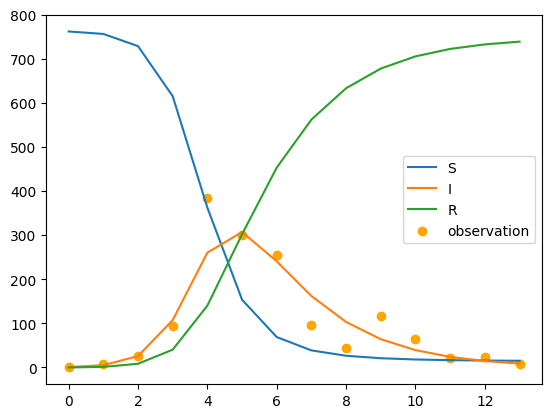

In [13]:
plt.plot(range(z.shape[0]), z[:,0], label='S')
plt.plot(range(z.shape[0]), z[:,1], label='I')
plt.plot(range(z.shape[0]), z[:,2], label='R')
plt.scatter(range(z.shape[0]), sim_observations, label='observation', color='orange')
plt.legend()

## Prior predictive

In [14]:
sir_predictive = Predictive(model, num_samples=110)

rng_key_draw = PRNGKey(11)

sir_sims = sir_predictive(rng_key=rng_key_draw,
         num_days = num_days,
         z_init = z_init)

In [15]:
sir_sims['z'].shape

(110, 14, 3)

In [16]:
z_prior_pred = sir_sims['z']

In [17]:
z_prior_mean = z_prior_pred.mean(axis=0)
z_prior_25 = np.quantile(z_prior_pred, 0.25, axis=0)
z_prior_75 = np.quantile(z_prior_pred, 0.75, axis=0)

In [18]:
ntimes = z_prior_mean.shape[0]

In [19]:
z_prior_mean.shape

(14, 3)

In [20]:
z_prior_pred.shape

(110, 14, 3)

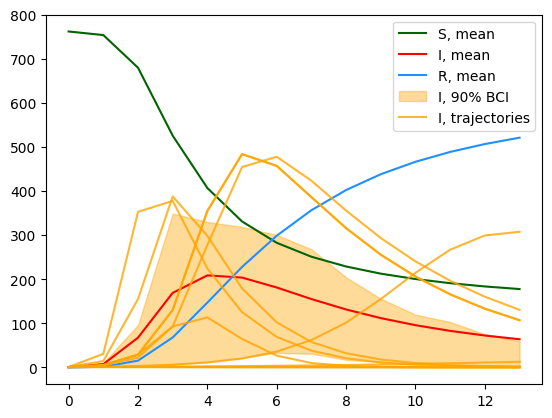

In [21]:
N_lines = 10

plt.plot(range(ntimes), z_prior_mean[:,0], label="S, mean", color="darkgreen")
plt.plot(range(ntimes), z_prior_mean[:,1], label="I, mean", color= "red")
plt.plot(range(ntimes), z_prior_mean[:,2], label="R, mean", color= "dodgerblue")

plt.fill_between(range(ntimes), z_prior_25[:, 1], z_prior_75[:,1], alpha=0.4, interpolate=True, label="I, 90% BCI", color="orange")

for j in range(N_lines):
    itr = int(z_prior_pred.shape[0]/N_lines)
    if j == 0:
      plt.plot(range(ntimes), z_prior_pred[j* itr,:, 1], alpha=0.8, color="orange", label="I, trajectories")
    plt.plot(range(ntimes), z_prior_pred[j* itr,:, 1], alpha=0.8, color="orange", label="")

plt.legend()


## Inference

In [22]:
# Define observed data (e.g., number of reported cases over time)
observed_data = jnp.array([3,8,26,76,225,298,258,233,189,128,68,29,14,4])

#observed_data = jnp.fmax(sim_observations, 0)
observed_data

Array([  3,   8,  26,  76, 225, 298, 258, 233, 189, 128,  68,  29,  14,
         4], dtype=int32)

In [23]:
# use dense_mass for better mixing rate
mcmc = MCMC(
        NUTS(model, dense_mass=True),
        num_warmup=1000,
        num_samples=1000,
        num_chains=1,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )

In [24]:
mcmc.run(rng_key=PRNGKey(11),
         num_days = num_days,
         z_init = z_init,
         observed_data=observed_data)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 295.11it/s, 7 steps of size 5.59e-01. acc. prob=0.91] 


In [25]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta      2.07      0.08      2.06      1.93      2.18    310.85      1.00
     gamma      0.51      0.04      0.51      0.45      0.58    364.51      1.00
   phi_inv      0.12      0.08      0.10      0.02      0.22    395.61      1.00

Number of divergences: 0


In [26]:
# Get posterior samples
posterior_samples = mcmc.get_samples()

In [27]:
# posterior predictive
sir_posterior_predictive = Predictive(model, posterior_samples)(PRNGKey(11), num_days = num_days, z_init = z_init)

In [28]:
observed_posterior_predictive = sir_posterior_predictive['observed']
observed_posterior_mean = observed_posterior_predictive.mean(axis=0)
observed_posterior_25 = np.quantile(observed_posterior_predictive, 0.05, axis=0)
observed_posterior_75 = np.quantile(observed_posterior_predictive, 0.95, axis=0)

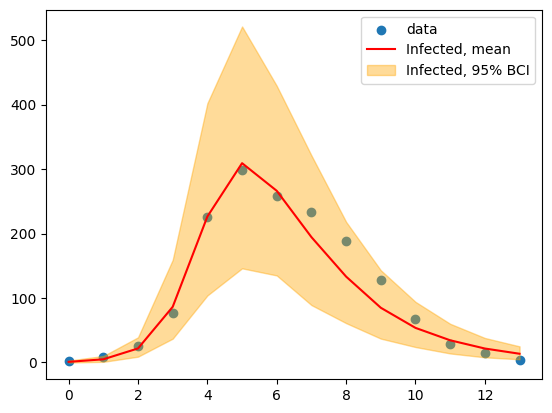

In [29]:
plt.scatter(range(num_days), observed_data, label='data')

plt.plot(range(ntimes), observed_posterior_mean, label="Infected, mean", color= "red")

plt.fill_between(range(ntimes), observed_posterior_25, observed_posterior_75, alpha=0.4, interpolate=True, label="Infected, 95% BCI", color="orange")

plt.legend()